In [3]:
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [4]:
spark

In [5]:
from pyspark import SparkContext
from pyspark.sql.functions import lit
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import col, udf, array, collect_list, regexp_replace, count, avg
from pyspark.sql.functions import desc, size, array
from pyspark.ml.fpm import FPGrowth 
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.sql.types import *
from pyspark.sql.types import FloatType, IntegerType, ArrayType
import time
import pandas as pd
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

## Dataframe Based API - Frequent Pattern Mining

This section shows how a recommender system is built with Freqent Pattern Mining (FPM) algorithm. This algorithm aims to identify underlying patterns in users' purchasing bahavior and recommend products if the user's current purchasing list matches some pattern.

### I. Data Pre-processing & Model Exploration

In [6]:
train_df = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/shared_data/train_df.json")
valid_df = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/shared_data/valid_df.json")
test_df = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/shared_data/test_df.json")
# The code of getting the three dataframe is the same as the ALS algorithm.

In [7]:
meta = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/data/metadata.json")

In [10]:
product_index = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/product_index.json")
# product_index lists original item id and corresponding numeric id we generated.

In [11]:
product = train_df.join(product_index, (train_df.Product_ID == product_index.ProductIndex), "left_outer").select(train_df.User_ID, train_df.Product_ID.alias('item_index'), product_index.itemId)
groupby_item = product.groupBy("itemId").agg(count("User_ID").alias("count")).cache()
item_info = groupby_item.join(meta, (groupby_item.itemId == meta.asin), "left_outer").cache()
item_info = item_info.select('itemId','count','brand','title','description').cache()
#item_info.write.json('item_info.json')

In [46]:
item_info.sort(desc("count")).show()

+----------+-----+---------------+--------------------+--------------------+
|    itemId|count|          brand|               title|         description|
+----------+-----+---------------+--------------------+--------------------+
|B007WTAJTO| 4983|        SanDisk|SanDisk Ultra 64G...|Perfect for today...|
|B00DR0PDNE| 4315|         Google|Google Chromecast...|                    |
|B003ES5ZUU| 4009|           null|AmazonBasics High...|                    |
|B0019EHU8G| 3697|    Mediabridge|Mediabridge ULTRA...|Mediabridge ULTRA...|
|B0074BW614| 3307|           null|                null|                null|
|B003ELYQGG| 3114|      Panasonic|Panasonic RPHJE12...|Panasonic In-Ear ...|
|B006GWO5WK| 3065|           null|                null|                null|
|B0002L5R78| 2706|       DVI Gear|DVI Gear HDMI Cab...|                    |
|B002WE6D44| 2687|           null|Transcend 8 GB Cl...|                    |
|B009SYZ8OC| 2602|           null|AmazonBasics Appl...|                    |

In [5]:
#item_info = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/item_info.json")

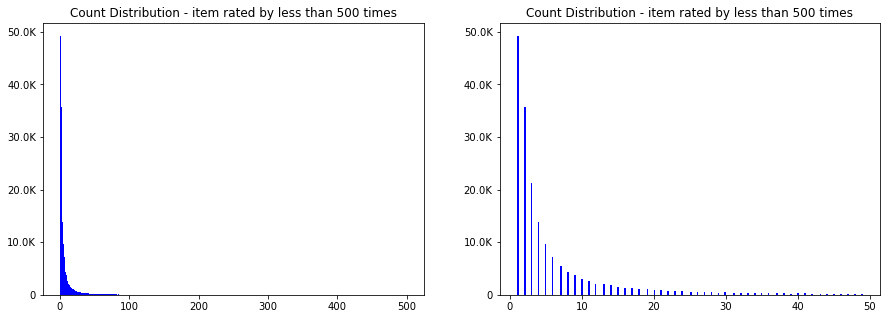

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 5)
hist(axes[0], [item_info.select('count').filter(col('count') < 500)], bins = 500,  color=['blue'])
axes[0].set_title('Count Distribution - item rated by less than 500 times')
#axes[0,0].legend()
hist(axes[1], [item_info.select('count').filter(col('count') < 50)], bins = 200,  color=['blue'])
axes[1].set_title('Count Distribution - item rated by less than 500 times')
plt.show()

Most of items are rated by less than 30 times from the histograms above.

In [49]:
groupby_item_user = df.groupBy("itemId","userId").agg(count('timestamp').alias("count")).cache()
item_info_2 = groupby_item_user.join(meta, (groupby_item_user.itemId == meta.asin), "left_outer").cache()
item_info_2 = item_info_2.select('userId','itemId','count','brand','title','description').cache()

In [52]:
item_info_2.filter(col('count') > 1).show()

+------+------+-----+-----+-----+-----------+
|userId|itemId|count|brand|title|description|
+------+------+-----+-----+-----+-----------+
+------+------+-----+-----+-----+-----------+



No product is rated twice by the same user. So assume each user will only buy a product once.

### II. Model Explore

In [12]:
groupby_user = train_df.groupBy("user_ID").agg(count('Product_ID').alias("count"))
groupby_user.show()

+-------+-----+
|user_ID|count|
+-------+-----+
| 270992|    1|
| 271186|    3|
| 271201|    2|
| 271266|   11|
| 271566|    1|
| 271690|    2|
| 272014|  179|
| 272238|    2|
| 272659|    1|
| 272712|   21|
| 272775|    1|
| 273145|    1|
| 273340|    1|
| 273499|    3|
| 274093|    7|
| 283620|    5|
| 283857|    4|
| 283969|    3|
| 284004|    2|
| 284028|    2|
+-------+-----+
only showing top 20 rows



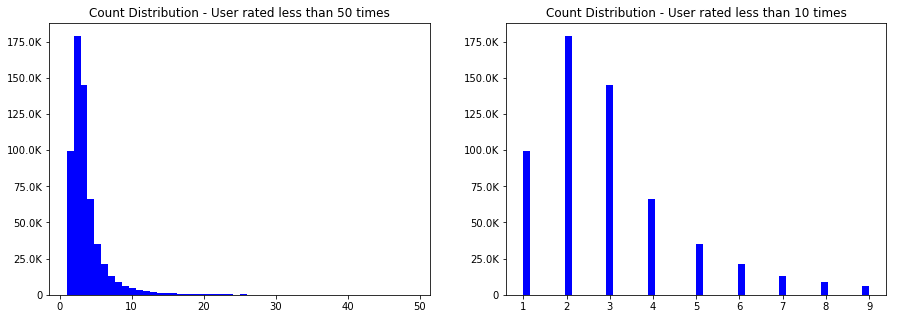

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 5)
hist(axes[0], [groupby_user.select('count').filter(col('count') < 50)], bins = 50,  color=['blue'])
axes[0].set_title('Count Distribution - User rated less than 50 times')
#axes[0,0].legend()
hist(axes[1], [groupby_user.select('count').filter(col('count') < 10)], bins = 50,  color=['blue'])
axes[1].set_title('Count Distribution - User rated less than 10 times')
plt.show()

Most of the users rated less than 10 products.

In [13]:
groupby = train_df.groupBy("User_ID").agg(collect_list("Product_ID"))
groupby = groupby.select(col("User_ID").alias("User_ID"), col("collect_list(Product_ID)").alias("Product_ID"))
#groupby = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/grouped_train.json")
groupby.show()

+-------+--------------------+
|User_ID|          Product_ID|
+-------+--------------------+
|     26|     [13, 106, 2510]|
|     29|[6840, 5530, 553,...|
|    474|[65833, 28897, 25...|
|    964|[1380, 12951, 13482]|
|   1677|        [1322, 8417]|
|   1697|         [9164, 403]|
|   1806|   [478, 68948, 352]|
|   1950|[4966, 88334, 140...|
|   2040|[2028, 3150, 1543...|
|   2214|[3761, 156435, 17...|
|   2250|[33297, 14, 36238...|
|   2453|       [1213, 16910]|
|   2509|[1624, 12875, 43513]|
|   2927|[65869, 51415, 75...|
|   3091|        [683, 10460]|
|   3506|     [1346, 2994, 3]|
|   4590|              [1614]|
|   4823|[5108, 16913, 329...|
|   5385|   [74140, 172, 309]|
|   5409|      [13688, 13282]|
+-------+--------------------+
only showing top 20 rows



In [86]:
groupby.count()

595383

minSupport is the minimum support for an itemset to be identified as frequent. The training set contains 595,383 users/transactions. For instance, to have an itemset appear at least 5 times among all transactions, the minSupport will be 0.0000085.

minConfidence is the minimum confidence for generating Association Rule. For example, if in the transactions itemset X appears 4 times, X and Y co-occur only 2 times, the confidence for the rule X => Y is then 2/4 = 0.5. The parameter will not affect the mining for frequent itemsets, but specify the minimum confidence for generating association rules from frequent itemsets.

In [14]:
fpGrowth = FPGrowth(itemsCol="Product_ID", minSupport= 0.0000085, minConfidence = 0.5 )
model = fpGrowth.fit(groupby)

In [15]:
item_set = model.freqItemsets.filter(size('items') > 1)
item_set.show()

+-----------+----+
|      items|freq|
+-----------+----+
|  [207, 48]|   6|
|  [207, 14]|  10|
|   [207, 7]|   8|
|  [207, 18]|  14|
| [207, 194]|  22|
|  [207, 94]|  12|
|  [207, 38]|   7|
| [207, 167]|   6|
|   [207, 0]|  10|
| [438, 115]|  35|
| [438, 248]|  22|
|  [438, 96]|  26|
|   [438, 9]|   9|
| [629, 423]|  13|
| [629, 361]|  15|
|   [629, 2]|   9|
| [629, 377]|  17|
|   [629, 3]|   7|
|[2082, 237]|   6|
|[4391, 693]|   8|
+-----------+----+
only showing top 20 rows



In [16]:
item_set.count()  #number of distinct item_set

9417

In [17]:
count_itemset = item_set.select('*',size('items').alias('item_set_size'))
count_itemset.show()

+-----------+----+-------------+
|      items|freq|item_set_size|
+-----------+----+-------------+
|  [207, 48]|   6|            2|
|  [207, 14]|  10|            2|
|   [207, 7]|   8|            2|
|  [207, 18]|  14|            2|
| [207, 194]|  22|            2|
|  [207, 94]|  12|            2|
|  [207, 38]|   7|            2|
| [207, 167]|   6|            2|
|   [207, 0]|  10|            2|
| [438, 115]|  35|            2|
| [438, 248]|  22|            2|
|  [438, 96]|  26|            2|
|   [438, 9]|   9|            2|
| [629, 423]|  13|            2|
| [629, 361]|  15|            2|
|   [629, 2]|   9|            2|
| [629, 377]|  17|            2|
|   [629, 3]|   7|            2|
|[2082, 237]|   6|            2|
|[4391, 693]|   8|            2|
+-----------+----+-------------+
only showing top 20 rows



In [18]:
count_itemset.groupBy("item_set_size").agg(count("items").alias("count")).show() # size of frequent item_set

+-------------+-----+
|item_set_size|count|
+-------------+-----+
|            3|  114|
|            4|    1|
|            2| 9302|
+-------------+-----+



In [19]:
fpGrowth2 = FPGrowth(itemsCol="Product_ID", minSupport= 0.00002, minConfidence = 0.5)
model2 = fpGrowth2.fit(groupby)
item_set2 = model2.freqItemsets.filter(size('items') > 1)
count_itemset2 = item_set2.select('*',size('items').alias('item_set_size'))

In [20]:
count_itemset2.groupBy("item_set_size").agg(count("items").alias("count")).show()

+-------------+-----+
|item_set_size|count|
+-------------+-----+
|            3|   15|
|            2| 1695|
+-------------+-----+



With a minimum support of 0.0000085, there are 9395 frequent itemsets contains two or more items and mostly a pair of items. If we increase the minSupport to 0.00002, which means an itemset will need to appear about 12 times to be considered. As a result, the number of itemset decreases significantly. 

In [42]:
AR = model.associationRules    # Association Rule
AR.show()

+--------------+----------+------------------+
|    antecedent|consequent|        confidence|
+--------------+----------+------------------+
|  [9355, 1227]|   [11172]|               0.5|
|  [9355, 1227]|     [469]|               0.5|
|   [4103, 500]|    [5894]|0.5454545454545454|
|   [4103, 500]|    [2701]|0.5454545454545454|
|   [4103, 500]|     [477]|0.5454545454545454|
|   [4103, 500]|    [6264]|0.6363636363636364|
|   [4103, 500]|    [3950]|0.6363636363636364|
|   [3047, 698]|     [500]|               0.6|
|  [5006, 2701]|     [477]|0.5454545454545454|
|[34212, 20900]|   [32129]|0.7777777777777778|
|       [16446]|      [22]|               0.5|
|  [4103, 2701]|     [477]|               0.5|
|  [4103, 2701]|    [3047]|               0.5|
|       [27634]|    [6311]|0.5454545454545454|
|    [1557, 97]|       [4]|               0.5|
|  [5991, 3047]|    [2701]|0.5384615384615384|
| [12177, 3950]|    [4103]|0.7777777777777778|
|  [6659, 4059]|     [400]|0.7272727272727273|
|   [3950, 50

### III. Parameter Selection (Validation)

In [57]:
groupby = train_df.groupBy('User_ID').agg(collect_list('Product_ID').alias('Product_ID'))
#groupby = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/grouped_train.json")
# dataframe:   user_ID, [list of products purchased by this user]

In [30]:
def user_type(lst):  # Define user type: frequent / infrequent
    if len(lst) > 15:
        return "F"
    else:
        return "NF"
user_type_udf = udf(user_type)

def match_count(array): # calculate match_count
    if array[1] == None:
        return 0
    else:
        count = len(set(array[0]).intersection(array[1]))
        return count
match_count_udf = udf(match_count)

def precision(array):
    if array[1] == None or len(set(array[1])) == 0:
        return float(0)
    else:
        count = len(set(array[0]).intersection(array[1]))
        precision = float(count * 100 /len(set(array[1])))
        return precision
precision_udf = udf(precision)

def recall(array):
    if array[1] == None or len(set(array[0])) == 0:
        return float(0)
    else:
        count = len(set(array[0]).intersection(array[1]))
        recall = float(count * 100 /len(set(array[0])))
        return recall
recall_udf = udf(recall)

def F_measure(array):
    if array[1] == None or len(set(array[1])) == 0 or len(set(array[0])) == 0:
        return 0
    else:
        count = len(set(array[0]).intersection(array[1]))
        precision = count * 100 /len(set(array[1]))
        recall = count * 100 /len(set(array[0]))
        if precision > 0 and recall > 0:
            F = float(2 * recall* precision) / float((recall + precision))
            return F
        else:
            return 0
F_udf = udf(F_measure)


def FPM(train, valid, minsupport = 0.0000085 , minconfidence = 0.5):
    # model training
    start = time.time()
    fpGrowth = FPGrowth(itemsCol="Product_ID", minSupport= minsupport, minConfidence=minconfidence)
    model = fpGrowth.fit(train)
    prediction = model.transform(train) #prediction

    prediction = prediction.withColumn("type", user_type_udf(col('Product_ID'))) #define user as frequent/non-frequent
    prediction.show()
    end = time.time()
    print 'Time for prediction:' + str(end - start)
    # model on validation set
    groupby_vali = valid.groupBy("User_ID").agg(collect_list("Product_ID"))
    groupby_vali = groupby_vali.select(col("User_ID").alias("User_ID"), col("collect_list(Product_ID)").alias("Bought"))
         
    df1 = groupby_vali.alias('df1')
    df2 = prediction.alias('df2')
    result = df1.join(df2, (df1.User_ID == df2.User_ID), "left_outer").select(df1.User_ID, df2.type, df1.Bought, df2.prediction)

    res = result.withColumn('match_count', match_count_udf(array('Bought','prediction')))
    res = res.withColumn('precision', precision_udf(array('Bought','prediction')))
    res = res.withColumn('recall', recall_udf(array('Bought','prediction')))
    res = res.withColumn('F_measure', F_udf(array('Bought','prediction')))
    #res.cache()
    return res
    

In [21]:
test1 = FPM(groupby, valid_df, minsupport = 0.0000085 , minconfidence = 0.5)

+-------+--------------------+----------+----+
|User_ID|          Product_ID|prediction|type|
+-------+--------------------+----------+----+
|     26|     [13, 106, 2510]|        []|  NF|
|     29|[6840, 5530, 553,...|        []|  NF|
|    474|[65833, 28897, 25...|        []|  NF|
|    964|[1380, 12951, 13482]|        []|  NF|
|   1677|        [1322, 8417]|        []|  NF|
|   1697|         [9164, 403]|        []|  NF|
|   1806|   [478, 68948, 352]|        []|  NF|
|   1950|[4966, 88334, 140...|        []|  NF|
|   2040|[2028, 3150, 1543...|        []|  NF|
|   2214|[3761, 156435, 17...|        []|   F|
|   2250|[33297, 14, 36238...|        []|  NF|
|   2453|       [1213, 16910]|        []|  NF|
|   2509|[1624, 12875, 43513]|        []|  NF|
|   2927|[65869, 51415, 75...|        []|  NF|
|   3091|        [683, 10460]|        []|  NF|
|   3506|     [1346, 2994, 3]|        []|  NF|
|   4590|              [1614]|        []|  NF|
|   4823|[5108, 16913, 329...|        []|  NF|
|   5385|   [

In [22]:
test1.groupby('type').count().show()

+----+------+
|type| count|
+----+------+
|   F|  6733|
|null| 18322|
|  NF|360000|
+----+------+



In [23]:
test1.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|   36|
|  NF|   43|
+----+-----+



In [24]:
test1.groupby('type').agg(avg('F_measure')).show()

+----+--------------------+
|type|      avg(F_measure)|
+----+--------------------+
|   F| 0.08867325662662043|
|null|                 0.0|
|  NF|0.009492620439988862|
+----+--------------------+



In [25]:
test2 = FPM(groupby, valid_df, minsupport = 0.0000085 , minconfidence = 0.3)

+-------+--------------------+----------+----+
|User_ID|          Product_ID|prediction|type|
+-------+--------------------+----------+----+
|     26|     [13, 106, 2510]|        []|  NF|
|     29|[6840, 5530, 553,...|        []|  NF|
|    474|[65833, 28897, 25...|        []|  NF|
|    964|[1380, 12951, 13482]|        []|  NF|
|   1677|        [1322, 8417]|        []|  NF|
|   1697|         [9164, 403]|        []|  NF|
|   1806|   [478, 68948, 352]|        []|  NF|
|   1950|[4966, 88334, 140...|        []|  NF|
|   2040|[2028, 3150, 1543...|        []|  NF|
|   2214|[3761, 156435, 17...|        []|   F|
|   2250|[33297, 14, 36238...|        []|  NF|
|   2453|       [1213, 16910]|        []|  NF|
|   2509|[1624, 12875, 43513]|        []|  NF|
|   2927|[65869, 51415, 75...|        []|  NF|
|   3091|        [683, 10460]|        []|  NF|
|   3506|     [1346, 2994, 3]|        []|  NF|
|   4590|              [1614]|        []|  NF|
|   4823|[5108, 16913, 329...|        []|  NF|
|   5385|   [

In [26]:
test2.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|  106|
|  NF|  453|
+----+-----+



In [27]:
test2.groupby('type').agg(avg('F_measure')).show()

+----+-------------------+
|type|     avg(F_measure)|
+----+-------------------+
|   F|0.27575305792961574|
|null|                0.0|
|  NF|  0.099888694362641|
+----+-------------------+



In [28]:
test3 = FPM(groupby, valid_df, minsupport = 0.0000085 , minconfidence = 0.1)

+-------+--------------------+-------------------+----+
|User_ID|          Product_ID|         prediction|type|
+-------+--------------------+-------------------+----+
|     26|     [13, 106, 2510]|                 []|  NF|
|     29|[6840, 5530, 553,...|                 []|  NF|
|    474|[65833, 28897, 25...|                 []|  NF|
|    964|[1380, 12951, 13482]|                 []|  NF|
|   1677|        [1322, 8417]|                 []|  NF|
|   1697|         [9164, 403]|                 []|  NF|
|   1806|   [478, 68948, 352]|                 []|  NF|
|   1950|[4966, 88334, 140...|                 []|  NF|
|   2040|[2028, 3150, 1543...|                 []|  NF|
|   2214|[3761, 156435, 17...|[1315, 435, 6, 221]|   F|
|   2250|[33297, 14, 36238...|              [633]|  NF|
|   2453|       [1213, 16910]|                 []|  NF|
|   2509|[1624, 12875, 43513]|                 []|  NF|
|   2927|[65869, 51415, 75...|                 []|  NF|
|   3091|        [683, 10460]|                 [

In [29]:
test3.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|  582|
|  NF| 3648|
+----+-----+



In [30]:
test3.groupby('type').agg(avg('F_measure')).show()

+----+------------------+
|type|    avg(F_measure)|
+----+------------------+
|   F|1.3067843318413719|
|null|               0.0|
|  NF|0.6757563193627745|
+----+------------------+



In [31]:
test4 = FPM(groupby, valid_df, minsupport = 0.00002 , minconfidence = 0.5)

+-------+--------------------+----------+----+
|User_ID|          Product_ID|prediction|type|
+-------+--------------------+----------+----+
|     26|     [13, 106, 2510]|        []|  NF|
|     29|[6840, 5530, 553,...|        []|  NF|
|    474|[65833, 28897, 25...|        []|  NF|
|    964|[1380, 12951, 13482]|        []|  NF|
|   1677|        [1322, 8417]|        []|  NF|
|   1697|         [9164, 403]|        []|  NF|
|   1806|   [478, 68948, 352]|        []|  NF|
|   1950|[4966, 88334, 140...|        []|  NF|
|   2040|[2028, 3150, 1543...|        []|  NF|
|   2214|[3761, 156435, 17...|        []|   F|
|   2250|[33297, 14, 36238...|        []|  NF|
|   2453|       [1213, 16910]|        []|  NF|
|   2509|[1624, 12875, 43513]|        []|  NF|
|   2927|[65869, 51415, 75...|        []|  NF|
|   3091|        [683, 10460]|        []|  NF|
|   3506|     [1346, 2994, 3]|        []|  NF|
|   4590|              [1614]|        []|  NF|
|   4823|[5108, 16913, 329...|        []|  NF|
|   5385|   [

In [32]:
test4.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|    5|
|  NF|   11|
+----+-----+



In [33]:
test4.groupby('type').agg(avg('F_measure')).show()

+----+--------------------+
|type|      avg(F_measure)|
+----+--------------------+
|   F|0.010360570743199172|
|null|                 0.0|
|  NF|0.002637844611528...|
+----+--------------------+



In [34]:
test5 = FPM(groupby, valid_df, minsupport = 0.00002 , minconfidence = 0.3)

+-------+--------------------+----------+----+
|User_ID|          Product_ID|prediction|type|
+-------+--------------------+----------+----+
|     26|     [13, 106, 2510]|        []|  NF|
|     29|[6840, 5530, 553,...|        []|  NF|
|    474|[65833, 28897, 25...|        []|  NF|
|    964|[1380, 12951, 13482]|        []|  NF|
|   1677|        [1322, 8417]|        []|  NF|
|   1697|         [9164, 403]|        []|  NF|
|   1806|   [478, 68948, 352]|        []|  NF|
|   1950|[4966, 88334, 140...|        []|  NF|
|   2040|[2028, 3150, 1543...|        []|  NF|
|   2214|[3761, 156435, 17...|        []|   F|
|   2250|[33297, 14, 36238...|        []|  NF|
|   2453|       [1213, 16910]|        []|  NF|
|   2509|[1624, 12875, 43513]|        []|  NF|
|   2927|[65869, 51415, 75...|        []|  NF|
|   3091|        [683, 10460]|        []|  NF|
|   3506|     [1346, 2994, 3]|        []|  NF|
|   4590|              [1614]|        []|  NF|
|   4823|[5108, 16913, 329...|        []|  NF|
|   5385|   [

In [35]:
test5.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|   42|
|  NF|  291|
+----+-----+



In [36]:
test5.groupby('type').agg(avg('F_measure')).show()

+----+-------------------+
|type|     avg(F_measure)|
+----+-------------------+
|   F|0.11536691307064968|
|null|                0.0|
|  NF|  0.066613643783789|
+----+-------------------+



In [37]:
test6 = FPM(groupby, valid_df, minsupport = 0.00002 , minconfidence = 0.1)

+-------+--------------------+----------+----+
|User_ID|          Product_ID|prediction|type|
+-------+--------------------+----------+----+
|     26|     [13, 106, 2510]|        []|  NF|
|     29|[6840, 5530, 553,...|        []|  NF|
|    474|[65833, 28897, 25...|        []|  NF|
|    964|[1380, 12951, 13482]|        []|  NF|
|   1677|        [1322, 8417]|        []|  NF|
|   1697|         [9164, 403]|        []|  NF|
|   1806|   [478, 68948, 352]|        []|  NF|
|   1950|[4966, 88334, 140...|        []|  NF|
|   2040|[2028, 3150, 1543...|        []|  NF|
|   2214|[3761, 156435, 17...|       [6]|   F|
|   2250|[33297, 14, 36238...|     [633]|  NF|
|   2453|       [1213, 16910]|        []|  NF|
|   2509|[1624, 12875, 43513]|        []|  NF|
|   2927|[65869, 51415, 75...|        []|  NF|
|   3091|        [683, 10460]|        []|  NF|
|   3506|     [1346, 2994, 3]|        []|  NF|
|   4590|              [1614]|        []|  NF|
|   4823|[5108, 16913, 329...|     [250]|  NF|
|   5385|   [

In [38]:
test6.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|  287|
|  NF| 2528|
+----+-----+



In [39]:
test6.groupby('type').agg(avg('F_measure')).show()

+----+------------------+
|type|    avg(F_measure)|
+----+------------------+
|   F| 0.740806251177769|
|null|               0.0|
|  NF|0.4841148558197569|
+----+------------------+



In [ ]:
#test7 = FPM(groupby, valid_df, minsupport = 0.000005 , minconfidence = 0.5)

test7 caused connection error, largely because of the parameters minsupport = 0.000005.

In [11]:
test8 = FPM(groupby, valid_df, minsupport = 0.000007 , minconfidence = 0.1)

+-------+--------------------+--------------------+----+
|User_ID|          Product_ID|          prediction|type|
+-------+--------------------+--------------------+----+
|     26|     [13, 106, 2510]|                  []|  NF|
|     29|[6840, 5530, 553,...|                  []|  NF|
|    474|[65833, 28897, 25...|                  []|  NF|
|    964|[1380, 12951, 13482]|                  []|  NF|
|   1677|        [1322, 8417]|                  []|  NF|
|   1697|         [9164, 403]|                  []|  NF|
|   1806|   [478, 68948, 352]|                  []|  NF|
|   1950|[4966, 88334, 140...|                  []|  NF|
|   2040|[2028, 3150, 1543...|                  []|  NF|
|   2214|[3761, 156435, 17...|[1315, 435, 1804,...|   F|
|   2250|[33297, 14, 36238...|               [633]|  NF|
|   2453|       [1213, 16910]|                  []|  NF|
|   2509|[1624, 12875, 43513]|                  []|  NF|
|   2927|[65869, 51415, 75...|                  []|  NF|
|   3091|        [683, 10460]| 

In [12]:
test8.groupby('type').count().show()  # In validation Set

+----+------+
|type| count|
+----+------+
|   F|  6733|
|null| 18322|
|  NF|360000|
+----+------+



In [13]:
test8.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|  671|
|  NF| 3992|
+----+-----+



In [14]:
test8.groupby('type').agg(avg('F_measure')).show()

+----+------------------+
|type|    avg(F_measure)|
+----+------------------+
|   F|1.4346585621451111|
|null|               0.0|
|  NF|0.7277510647917694|
+----+------------------+



In [ ]:
#test9 = FPM(groupby, valid_df, minsupport = 0.0000065 , minconfidence = 0.1) task failed

For the purpose of having at least one correct recommendation/prediction for more users, (minsupport = 0.000007, minconfidence = 0.1) is selected.

In [ ]:
#prediction = spark.read.json("/Users/zhichaoyang/Desktop/personalization_final/prediction_from_model.json")

### IV. Validation Set Product Coverage

In [58]:
vali_result = FPM(groupby, valid_df, minsupport = 0.000007 , minconfidence = 0.1)

+-------+--------------------+--------------------+----+
|User_ID|          Product_ID|          prediction|type|
+-------+--------------------+--------------------+----+
|     26|     [13, 106, 2510]|                  []|  NF|
|     29|[6840, 5530, 553,...|                  []|  NF|
|    474|[65833, 28897, 25...|                  []|  NF|
|    964|[1380, 12951, 13482]|                  []|  NF|
|   1677|        [1322, 8417]|                  []|  NF|
|   1697|         [9164, 403]|                  []|  NF|
|   1806|   [478, 68948, 352]|                  []|  NF|
|   1950|[4966, 88334, 140...|                  []|  NF|
|   2040|[2028, 3150, 1543...|                  []|  NF|
|   2214|[3761, 156435, 17...|[1315, 435, 1804,...|   F|
|   2250|[33297, 14, 36238...|               [633]|  NF|
|   2453|       [1213, 16910]|                  []|  NF|
|   2509|[1624, 12875, 43513]|                  []|  NF|
|   2927|[65869, 51415, 75...|                  []|  NF|
|   3091|        [683, 10460]| 

In [65]:
vali_result.show()

+-------+----+--------------------+--------------------+-----------+---------+------+------------------+
|User_ID|type|              Bought|          prediction|match_count|precision|recall|         F_measure|
+-------+----+--------------------+--------------------+-----------+---------+------+------------------+
|     29|  NF|              [3959]|                  []|          0|      0.0|   0.0|                 0|
|    474|  NF|              [5540]|                  []|          0|      0.0|   0.0|                 0|
|   1677|  NF|             [32179]|                  []|          0|      0.0|   0.0|                 0|
|   1806|  NF|              [6459]|                  []|          0|      0.0|   0.0|                 0|
|   2040|  NF|             [47560]|                  []|          0|      0.0|   0.0|                 0|
|   2214|   F|[28167, 22799, 89...|[1315, 435, 1804,...|          0|      0.0|   0.0|                 0|
|   2453|  NF|             [16365]|                  []

In [59]:
check = vali_result.select('User_ID','Bought','prediction')

In [60]:
ind = udf(lambda uid: 1, IntegerType())
check = check.withColumn('index', ind(col('User_ID')))

In [61]:
product_check = check.groupBy('index').agg(collect_list('prediction'))

In [62]:
product_check_rdd = product_check.rdd

In [63]:
product_check_rdd = product_check_rdd.flatMap(lambda x: [item for sublist in x[1] for item in sublist ])

In [64]:
product_check_rdd.distinct().count() # 1004 distinct products in total in the recommendation.

1004

### V. Further Extend

Since the FPM does not provide recommendation for all users and it covers only a small part of items, the model is furter extended by recommending a combination of popular items and other items.

In [22]:
groupby_product = train_df.groupBy('Product_ID').agg(count('User_ID')).cache()
groupby_product.show()

+----------+--------------+
|Product_ID|count(User_ID)|
+----------+--------------+
|       474|           338|
|      3091|           100|
|     13638|            24|
|      2529|           109|
|      4894|            65|
|     13248|            25|
|      3506|            89|
|    102613|             3|
|    117936|             2|
|     74185|             4|
|       964|           218|
|        26|          1468|
|      1806|           136|
|        29|          1457|
|     18295|            14|
|     13518|            27|
|      2453|           106|
|     23019|            18|
|      1697|           153|
|     38878|             9|
+----------+--------------+
only showing top 20 rows



In [23]:
F_item = groupby_product.filter(col('count(User_ID)') > 100).select('Product_ID').collect()
NF_item = groupby_product.filter(col('count(User_ID)') <= 100).select('Product_ID').collect()

In [137]:
len(F_item)  # 2804 popular items

2804

In [138]:
len(NF_item)

184155

In [24]:
fpGrowth = FPGrowth(itemsCol="Product_ID", minSupport= 0.000007, minConfidence=0.1)
model = fpGrowth.fit(groupby)
prediction = model.transform(groupby)

In [25]:
prediction.show()  # Initial prediction from FPM model

+-------+--------------------+--------------------+
|User_ID|          Product_ID|          prediction|
+-------+--------------------+--------------------+
|     26|     [13, 106, 2510]|                  []|
|     29|[6840, 5530, 553,...|                  []|
|    474|[65833, 28897, 25...|                  []|
|    964|[1380, 12951, 13482]|                  []|
|   1677|        [1322, 8417]|                  []|
|   1697|         [9164, 403]|                  []|
|   1806|   [478, 68948, 352]|                  []|
|   1950|[4966, 88334, 140...|                  []|
|   2040|[2028, 3150, 1543...|                  []|
|   2214|[3761, 156435, 17...|[1315, 435, 1804,...|
|   2250|[33297, 14, 36238...|               [633]|
|   2453|       [1213, 16910]|                  []|
|   2509|[1624, 12875, 43513]|                  []|
|   2927|[65869, 51415, 75...|                  []|
|   3091|        [683, 10460]|                  []|
|   3506|     [1346, 2994, 3]|                  []|
|   4590|   

In [38]:
import random
def extension(array):  # Randomly recommend 8 items from popular products and 5 items from other products. Remove products that have been purchased.
    if array[0] == None:
        lst = []
    else:
        lst =  array[0]
        
    for i in range(8):
        index = random.randint(0,2803)
        if F_item[index].Product_ID not in lst and F_item[index].Product_ID not in array[1] : #and F_item[index].Product_ID not in array[1] 
            lst.append(F_item[index].Product_ID)
    for j in range(5):
        index2 = random.randint(0,184154)
        if NF_item[index2].Product_ID not in lst and NF_item[index].Product_ID not in array[1]  : #and NF_item[index].Product_ID not in array[1] 
            lst.append(NF_item[index2].Product_ID)   
    return lst

extension_udf = udf(extension)
prediction_ext = prediction.withColumn('prediction', extension_udf(array('prediction','Product_ID')))

In [42]:
prediction_ext.show()

+-------+--------------------+--------------------+----+
|User_ID|          Product_ID|          prediction|type|
+-------+--------------------+--------------------+----+
|     26|     [13, 106, 2510]|[1134, 964, 1798,...|  NF|
|     29|[6840, 5530, 553,...|[2759, 2924, 436,...|  NF|
|    474|[65833, 28897, 25...|[1698, 1376, 1482...|  NF|
|    964|[1380, 12951, 13482]|[2652, 149, 1262,...|  NF|
|   1677|        [1322, 8417]|[1374, 1853, 2298...|  NF|
|   1697|         [9164, 403]|[672, 1918, 1644,...|  NF|
|   1806|   [478, 68948, 352]|[749, 2919, 1976,...|  NF|
|   1950|[4966, 88334, 140...|[1198, 3131, 290,...|  NF|
|   2040|[2028, 3150, 1543...|[706, 327, 2680, ...|  NF|
|   2214|[3761, 156435, 17...|[1315, 435, 1804,...|   F|
|   2250|[33297, 14, 36238...|[633, 1600, 1127,...|  NF|
|   2453|       [1213, 16910]|[1811, 1083, 1938...|  NF|
|   2509|[1624, 12875, 43513]|[14, 955, 2682, 4...|  NF|
|   2927|[65869, 51415, 75...|[2725, 2340, 571,...|  NF|
|   3091|        [683, 10460]|[

In [ ]:
schema = ArrayType(StringType(), containsNull=False)
udf_foo = udf(lambda x:x, schema)
prediction_ext = prediction_ext.withColumn("prediction",udf_foo("prediction"))

#### Results On Validation Set

In [52]:
prediction_ext = prediction_ext.withColumn("type", user_type_udf(col('Product_ID')))
groupby_valid = valid_df.groupBy("User_ID").agg(collect_list("Product_ID"))
groupby_valid = groupby_valid.select(col("User_ID").alias("User_ID"), col("collect_list(Product_ID)").alias("Bought"))

In [53]:
df1 = groupby_valid.alias('df1')
df2 = prediction_ext.alias('df2')
result_ext = df1.join(df2, (df1.User_ID == df2.User_ID), "left_outer").select(df1.User_ID, df2.type, df1.Bought, df2.prediction)

In [54]:
res_ext = result_ext.withColumn('match_count', match_count_udf(array('Bought','prediction')))
res_ext = res_ext.withColumn('precision', precision_udf(array('Bought','prediction')))
res_ext = res_ext.withColumn('recall', recall_udf(array('Bought','prediction')))
res_ext = res_ext.withColumn('F_measure', F_udf(array('Bought','prediction')))

In [55]:
res_ext.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|  712|
|  NF| 4572|
+----+-----+



In [56]:
res_ext.groupby('type').agg(avg('F_measure')).show()

+----+-------------------+
|type|     avg(F_measure)|
+----+-------------------+
|   F| 0.7434666578001807|
|null|                0.0|
|  NF|0.15091490125154816|
+----+-------------------+



### VI. Apply to the test set

#### Step 1. FPM Model

In [15]:
test_set = FPM(groupby, test_df, minsupport = 0.000007 , minconfidence = 0.1)

+-------+--------------------+--------------------+----+
|User_ID|          Product_ID|          prediction|type|
+-------+--------------------+--------------------+----+
|     26|     [13, 106, 2510]|                  []|  NF|
|     29|[6840, 5530, 553,...|                  []|  NF|
|    474|[65833, 28897, 25...|                  []|  NF|
|    964|[1380, 12951, 13482]|                  []|  NF|
|   1677|        [1322, 8417]|                  []|  NF|
|   1697|         [9164, 403]|                  []|  NF|
|   1806|   [478, 68948, 352]|                  []|  NF|
|   1950|[4966, 88334, 140...|                  []|  NF|
|   2040|[2028, 3150, 1543...|                  []|  NF|
|   2214|[3761, 156435, 17...|[1315, 435, 1804,...|   F|
|   2250|[33297, 14, 36238...|               [633]|  NF|
|   2453|       [1213, 16910]|                  []|  NF|
|   2509|[1624, 12875, 43513]|                  []|  NF|
|   2927|[65869, 51415, 75...|                  []|  NF|
|   3091|        [683, 10460]| 

In [20]:
test_set.groupby('type').count().show()

+----+------+
|type| count|
+----+------+
|   F|  6727|
|null| 18379|
|  NF|360781|
+----+------+



In [16]:
test_set.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|  677|
|  NF| 3879|
+----+-----+



In [17]:
test_set.groupby('type').agg(avg('F_measure')).show()

+----+------------------+
|type|    avg(F_measure)|
+----+------------------+
|   F|1.4750507651366502|
|null|               0.0|
|  NF|0.7010225998641106|
+----+------------------+



#### Step 2.

In [41]:
prediction_ext = prediction_ext.withColumn("type", user_type_udf(col('Product_ID'))) 
groupby_test = test_df.groupBy("User_ID").agg(collect_list("Product_ID"))
groupby_test = groupby_test.select(col("User_ID").alias("User_ID"), col("collect_list(Product_ID)").alias("Bought"))

In [43]:
schema = ArrayType(StringType(), containsNull=False)
udf_foo = udf(lambda x:x, schema)
prediction_ext = prediction_ext.withColumn("prediction",udf_foo("prediction"))

In [46]:
df1 = groupby_test.alias('df1')
df2 = prediction_ext.alias('df2')
result_ext = df1.join(df2, (df1.User_ID == df2.User_ID), "left_outer").select(df1.User_ID, df2.type, df1.Bought, df2.prediction)

In [48]:
res_ext = result_ext.withColumn('match_count', match_count_udf(array('Bought','prediction')))
res_ext = res_ext.withColumn('precision', precision_udf(array('Bought','prediction')))
res_ext = res_ext.withColumn('recall', recall_udf(array('Bought','prediction')))
res_ext = res_ext.withColumn('F_measure', F_udf(array('Bought','prediction')))

In [50]:
res_ext.filter(col('match_count')>0).groupby('type').count().show()

+----+-----+
|type|count|
+----+-----+
|   F|  717|
|  NF| 4465|
+----+-----+



In [51]:
res_ext.groupby('type').agg(avg('F_measure')).show()

+----+-------------------+
|type|     avg(F_measure)|
+----+-------------------+
|   F| 0.7674166904161434|
|null|                0.0|
|  NF|0.14649987738426934|
+----+-------------------+

